# 문제
Implement the same model, and train it with Adam optimizer using PyTorch. Use Google Colaboratory as your development environment. Turn your .ipynb file in here.

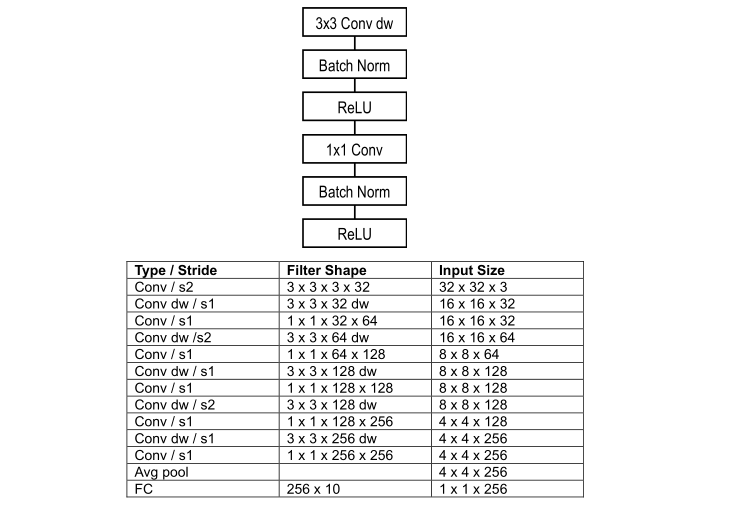

## 1. settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Pytorch
import torch.nn as nn
from torchsummary import summary
import torch 
import torchvision
import torchvision.transforms as transforms

In [3]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 2. CIFAR-10 데이터 불러오기 & EDA

- 데이터 불러오기

In [4]:
# Hyper parameters
num_epochs = 140
num_classes = 10
batch_size = 300
learning_rate = 0.001
dropout = 0.1

In [5]:
# Download and construct CIFAR-10 dataset.
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transforms.ToTensor(),
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Fetch one data pair (read data from disk).
image, label = train_dataset[0]
print (image.size())
print (label)

torch.Size([3, 32, 32])
6


In [7]:
# Data loader (this provides queues and threads in a very simple way).
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=64, 
                                          shuffle=False)

In [8]:
image, label = test_dataset[0]
print (image.size())
print (label)

torch.Size([3, 32, 32])
3


In [9]:
# # When iteration starts, queue and thread start to load data from files.
# data_iter = iter(train_loader)

# # Mini-batch images and labels.
# images, labels = data_iter.next()

# # Actual usage of the data loader is as below.
# for images, labels in train_loader:
#     # Training code should be written here.
#     pass


## 3. 모델 만들기

- overfitting 방지하기 위해 dropout 사용
  - dropout = 0.1

In [10]:
class MobileNet(nn.Module):
    def __init__(self, ch_in, n_classes):
        super(MobileNet, self).__init__()

        def conv_bn(inp, oup, stride):
            return nn.Sequential(
                nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1)
                )

        def conv_dw(inp, oup, stride):
            return nn.Sequential(
                # dw
                nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
                nn.BatchNorm2d(inp),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1),

                # pw
                nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
                nn.ReLU(inplace=True),
                nn.Dropout(0.1)
                )

        self.model = nn.Sequential(
            #Conv/s2
            conv_bn(ch_in, 32, 2),
            #Conv dw/s1
            conv_dw(32, 32, 1),
            #Conv/s1
            conv_bn(32, 64, 1),
            #Conv dw/s2
            conv_dw(64, 64, 2),
            #Conv/s1
            conv_bn(64, 128, 1),
            #Conv dw/s1
            conv_dw(128, 128, 1),
            #Conv/s1
            conv_bn(128, 128, 1),
            #Conv dw/s2
            conv_dw(128, 128, 2),
            #Conv/s1
            conv_bn(128, 256, 1),
            #Conv dw/s1
            conv_dw(256, 256, 1),
            #Conv/s1
            conv_bn(256, 256, 1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 256)
        x = self.fc(x)
        return x

model = MobileNet(ch_in=3, n_classes=10).to(device)


In [11]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
              ReLU-3           [-1, 32, 16, 16]               0
           Dropout-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 32, 16, 16]             288
       BatchNorm2d-6           [-1, 32, 16, 16]              64
              ReLU-7           [-1, 32, 16, 16]               0
           Dropout-8           [-1, 32, 16, 16]               0
            Conv2d-9           [-1, 32, 16, 16]           1,024
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

## 4. 학습 시키기

```
# Hyper parameters
num_epochs = 140
num_classes = 10
batch_size = 300
learning_rate = 0.001
dropout = 0.1
```

In [12]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))


Epoch [1/140], Step [100/782], Loss: 1.7152
Epoch [1/140], Step [200/782], Loss: 1.7840
Epoch [1/140], Step [300/782], Loss: 1.5722
Epoch [1/140], Step [400/782], Loss: 1.3420
Epoch [1/140], Step [500/782], Loss: 1.6843
Epoch [1/140], Step [600/782], Loss: 1.4336
Epoch [1/140], Step [700/782], Loss: 1.4487
Epoch [2/140], Step [100/782], Loss: 1.3060
Epoch [2/140], Step [200/782], Loss: 1.1819
Epoch [2/140], Step [300/782], Loss: 1.4033
Epoch [2/140], Step [400/782], Loss: 1.2080
Epoch [2/140], Step [500/782], Loss: 1.1513
Epoch [2/140], Step [600/782], Loss: 1.2202
Epoch [2/140], Step [700/782], Loss: 1.3931
Epoch [3/140], Step [100/782], Loss: 1.2336
Epoch [3/140], Step [200/782], Loss: 1.2718
Epoch [3/140], Step [300/782], Loss: 1.1495
Epoch [3/140], Step [400/782], Loss: 1.0110
Epoch [3/140], Step [500/782], Loss: 1.0335
Epoch [3/140], Step [600/782], Loss: 0.8311
Epoch [3/140], Step [700/782], Loss: 1.1073
Epoch [4/140], Step [100/782], Loss: 0.8401
Epoch [4/140], Step [200/782], L

##5. 결과 확인

In [14]:
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the 10000 test images: 84.35 %


코드 참고
```
https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/convolutional_neural_network/main.py
```
```
https://github.com/jmjeon94/MobileNet-Pytorch/blob/master/MobileNetV1.py
```
